In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from dataset import *
from encoder import Encoder
from decoder import DecodeNext, Decoder
from predictor import Predictor

from IPython.display import Image
%load_ext autoreload
%autoreload 2

# write gpu wiki page

In [2]:
DATADIR = './data/gdb13/'
OUTDIR = './run9/'
LOGFILE = os.path.join(OUTDIR, 'log.csv')
DATASPEC_FILE = os.path.join(DATADIR, 'spec.json')

dataspec = fetch_params(DATASPEC_FILE)
modelspec = make_params(hidden_dim=512, latent_dim=256, pred_dim=64, dropout=0.15)

### Data & Model Parameters

In [3]:
trainset, testset = make_data(DATADIR, n=10000)

### Model

In [4]:
encoder = Encoder(modelspec, dataspec)
encoder.load_state_dict(torch.load(OUTDIR + 'encoder_weights.pth'))

decoder = Decoder(modelspec, dataspec)
decoder.load_state_dict(torch.load(OUTDIR + 'decoder_weights.pth'))

predictor = Predictor(modelspec, dataspec)
predictor.load_state_dict(torch.load(OUTDIR + 'predictor_weights.pth'))

<All keys matched successfully>

OC1CCCCC2=CC=C(N2)OC1		C1C2OCC34CCC(C[NH2+]3)C1OC24
OC1CCCCC2=CC=C(N2)OC1		C1C2OCC34CCC(C[NH2+]3)C1OC24
Euclidean Distance of Means: 5.129253387451172
Euclidean Distance of Samples: 22.81145668029785


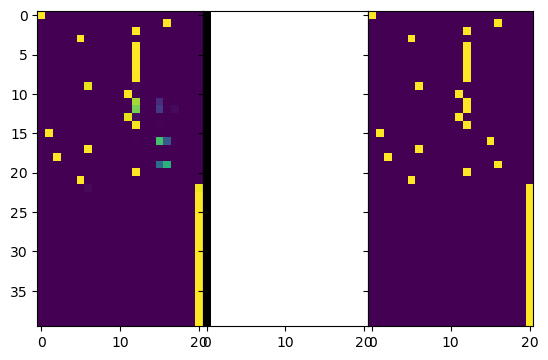

In [5]:
sample = testset.hots[random.sample(range(1, len(testset)), 2)]

s1, s2 = sample[0:1], sample[1:]

print(f'{from_hot(s1, dataspec.alphabet)[0]}\t\t{from_hot(s2, dataspec.alphabet)[0]}')

mu1, logvar1, z1 = encoder(s1)
mu2, logvar2, z2 = encoder(s2)

s1_pred = decoder(z1)
s2_pred = decoder(z2)

d1 = torch.argmax(s1, dim=2) != torch.argmax(s1_pred, dim=2)

print(f'{from_hot(s1_pred, dataspec.alphabet)[0]}\t\t{from_hot(s2_pred, dataspec.alphabet)[0]}')

print(f"Euclidean Distance of Means: {float(torch.pow(torch.sum(torch.pow(mu1 - mu2, 2)), 0.5))}")
print(f"Euclidean Distance of Samples: {float(torch.pow(torch.sum(torch.pow(z1 - z2, 2)), 0.5))}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)

ax1.imshow(torch.softmax(s1_pred, dim=2).squeeze(0).detach().numpy())
ax2.imshow(d1.permute(1, 0).detach().numpy(), cmap='gray')
ax3.imshow(torch.softmax(s1, dim=2).squeeze(0).detach().numpy())

plt.subplots_adjust(wspace=0, hspace=0)

## Test

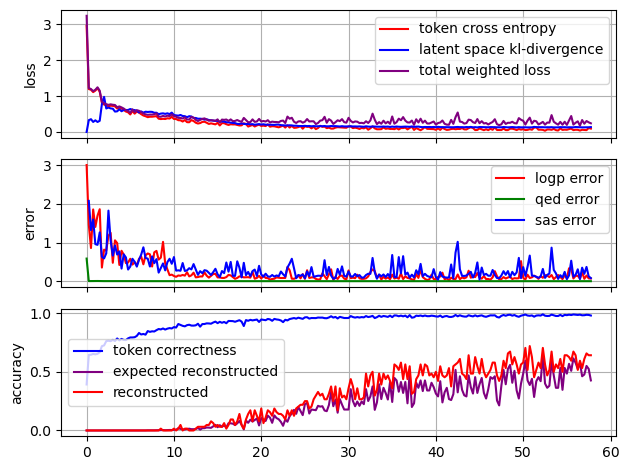

In [6]:
log = pd.read_csv('run9/log.csv')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

every = 100

epoch = log['i'][::every] * (32/1280000)

ax1.set_ylabel('loss')
ax1.plot(epoch, log['ce'][::every], color='red', label='token cross entropy')
ax1.plot(epoch, log['kl'][::every], color='blue', label='latent space kl-divergence')
ax1.plot(epoch, log['loss'][::every], color='purple', label='total weighted loss')
ax1.grid()
ax1.legend()

ax2.set_ylabel('error')
ax2.plot(epoch, log['logp'][::every], color='red', label='logp error')
ax2.plot(epoch, log['qed'][::every], color='green', label='qed error')
ax2.plot(epoch[1:], log['sas'][100::every], color='blue', label='sas error')
ax2.grid()
ax2.legend()

ax3.set_ylabel('accuracy')
ax3.plot(epoch, log['accuracy'][::every], color='blue', label='token correctness')
ax3.plot(epoch, (log['accuracy'][::every] ** dataspec.smile_len), color='purple', label='expected reconstructed')
ax3.plot(epoch, log['prec'][::every], color='red', label='reconstructed')
ax3.grid()
ax3.legend()

#plt.savefig('run.png')

plt.tight_layout()

In [10]:
log['accuracy']

0        0.391797
1        0.578906
2        0.558984
3        0.593750
4        0.601172
           ...   
23184    0.992187
23185    0.978906
23186    0.984766
23187    0.976563
23188    0.988672
Name: accuracy, Length: 23189, dtype: float64